# Feature and Model Selection Using Random Forest Classifier

In this tutorial, we will perform feature selection using a Random Forest classifier within a multi-output classification task. We will use a dataset and preprocess the data to identify the most important features that contribute to the classification accuracy.

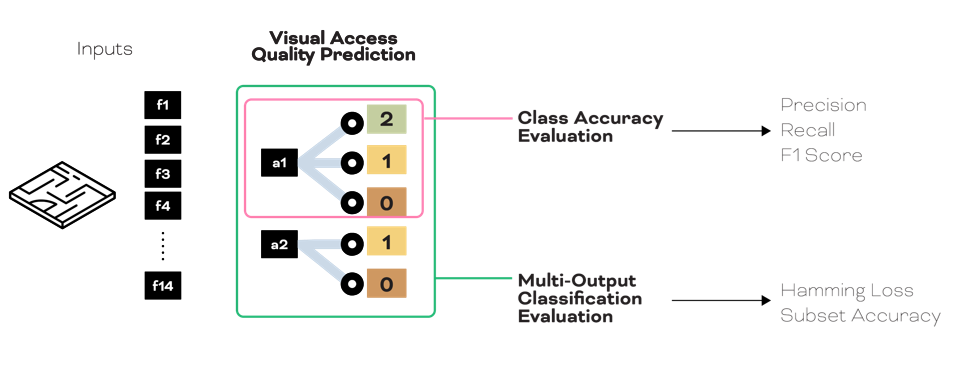

## Libraries Required
We begin by importing the necessary libraries.<br>
If you do not have the packages installed yet, make sure to install using pip<br>
`pip install pandas` <br>
`pip install numpy` <br>
`pip install matplotlib` <br>
`pip install scikit-learn` <br>
`pip install seaborn` <br>

The versions used in this example were the following: <br>
pandas | 2.0.3<br>
numpy | 1.24.3<br>
matplotlib | 3.7.2<br>
scikit-learn | 1.4.2<br>
seaborn | 0.12.2<br>


In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, hamming_loss, accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns


## Step 1: Load and Explore the Dataset

Here, we load the dataset into a pandas DataFrame and explore its shape and basic statistics to understand its structure.<br>
## <u>Make sure to update the file path when loading the dataset!</u>


In [16]:
import os

# Define the path to your directory
path = 'C:/Users/Home PC/Documents/P5/ProjectCode/Expanded_Experiment/Files/'
os.chdir(path)

training_df = pd.read_excel('Training/training_dataset_P5.xlsx', 'Sheet1')

print('training data loaded successfully!')
training_df

training data loaded successfully!


,apartment_id,site_id,building_id,plan_id,floor_id,unit_id,area_id,unit_usage,entity_type,entity_subtype,geometry,elevation,height,LIV_KIT,LIV_BED1,LIV_BED2,LIV_BED3,LIV_BED4,LIV_BED5,LIV_BED6,# OF BEDS,LIV_BATH1,LIV_BATH2,LIV_BATH3,# OF BATH,invalid_geometry,LIV_KIT_bin,LIV_KIT_bin_mapped,layout_compactness,layout_std_walllengths,layout_perimeter,layout_door_perimeter,layout_open_perimeter,layout_number_of_doors,connectivity_entrance_door_distance_max,connectivity_entrance_door_distance_mean,connectivity_entrance_door_distance_median,connectivity_entrance_door_distance_min,connectivity_entrance_door_distance_p20,connectivity_entrance_door_distance_p80,connectivity_entrance_door_distance_stddev,connectivity_betweenness_centrality_max,connectivity_betweenness_centrality_mean,connectivity_betweenness_centrality_median,connectivity_betweenness_centrality_min,connectivity_betweenness_centrality_p20,connectivity_betweenness_centrality_p80,connectivity_betweenness_centrality_stddev,connectivity_closeness_centrality_max,connectivity_closeness_centrality_mean,connectivity_closeness_centrality_median,connectivity_closeness_centrality_min,connectivity_closeness_centrality_p20,connectivity_closeness_centrality_p80,connectivity_closeness_centrality_stddev,connectivity_bathroom_distance_max,connectivity_bathroom_distance_mean,connectivity_bathroom_distance_median,connectivity_bathroom_distance_min,connectivity_bathroom_distance_p20,connectivity_bathroom_distance_p80,connectivity_bathroom_distance_stddev,connectivity_kitchen_distance_max,connectivity_kitchen_distance_mean,connectivity_kitchen_distance_median,connectivity_kitchen_distance_min,connectivity_kitchen_distance_p20,connectivity_kitchen_distance_p80,connectivity_kitchen_distance_stddev,layout_biggest_rectangle_length,layout_biggest_rectangle_width
0,faefdb324eff14ab02268712d80acb7d,85,71,6741,11138,53095,419054,RESIDENTIAL,area,LIVING,POLYGON ((-7.5220084330555963 2.16349213609409...,8.7,2.6,0.375000,2.250000,0.0000,0.000000,0.0,0.0,0,3,0.000000,0.000000,0.0,2,Unit_id 53095: VALID GEOMETRY,1_sufficient,1,0.643464,1.576666,25.548752,3.995188,0,3,13.75,10.529032,10.25,7.50,9.25,11.75,1.357314,0.072634,0.008724,0.007980,0.000000,0.001848,0.013678,0.007729,0.042253,0.034388,0.034994,0.025864,0.030589,0.037695,0.003777,13.75,9.800403,9.50,6.50,8.25,11.50,1.692303,10.75,6.901613,6.75,3.50,5.25,8.50,1.645987,5.658517,5.546962
1,39e462db543c918e9dd606e0be4bd08c,10965,15885,36002,41112,134183,1418848,RESIDENTIAL,area,LIVING,POLYGON ((3.7200228690791732 -4.55284359245765...,0.0,2.6,0.125000,0.000000,0.0000,0.000000,0.0,0.0,0,3,0.000000,0.000000,0.0,2,Unit_id 134183: VALID GEOMETRY,0_insufficient,0,0.723587,1.457574,19.904560,1.398150,0,2,9.25,6.101064,5.75,2.75,4.50,7.75,1.694705,0.178170,0.010241,0.005340,0.000000,0.001599,0.017928,0.014399,0.035698,0.027501,0.027384,0.021842,0.024236,0.030391,0.003259,12.50,9.351064,9.00,6.00,7.75,11.00,1.694705,9.25,6.101064,5.75,2.75,4.50,7.75,1.694705,5.693418,3.905336
2,63b72dc183cedd152d68e431e4755912,10965,15885,35990,41122,134200,1418611,RESIDENTIAL,area,LIVING,POLYGON ((-0.1435814985152231 0.38055450925636...,2.9,2.6,0.000000,0.000000,0.0000,0.000000,0.0,0.0,0,3,0.047619,0.000000,0.0,2,Unit_id 134200: VALID GEOMETRY,0_insufficient,0,0.666554,2.127253,26.898634,4.027087,0,3,11.75,8.532885,8.50,5.00,7.00,10.00,1.617202,0.130552,0.009000,0.007253,0.000000,0.002296,0.012653,0.010595,0.037570,0.030822,0.031578,0.023203,0.027282,0.033900,0.003522,11.00,7.905941,8.00,4.50,6.50,9.25,1.564161,10.25,7.165842,7.25,3.75,5.75,8.50,1.549624,8.605010,4.249354
3,e34971cb892dcecc265250c724afd576,10187,14796,33530,39162,130199,1368775,RESIDENTIAL,area,LIVING,POLYGON ((-0.8601146743973374 -7.7752184071551...,8.7,2.6,1.000000,0.062500,0.4375,0.000000,0.0,0.0,0,4,0.000000,0.000000,0.0,2,Unit_id 130199: VALID GEOMETRY,2_preferred,2,0.610187,1.878598,24.983647,0.000000,0,0,8.75,6.072581,6.25,2.50,5.00,7.25,1.314252,0.101877,0.008725,0.006975,0.000001,0.002374,0.011671,0.

# Step 2: assign labels for prediction and visualize distribution 
Visualize the distribution of visual sightlines between living to kitchen. <br>
<br>
Assign the labels for living to bathroom sightlines. In this instance, at least one bathroom should be visible to receive a positive label 'sufficient'

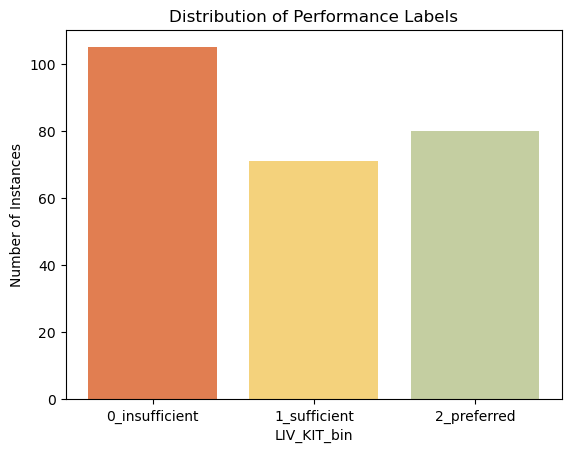

Number of unique 'unit_id' values: 256
apartment_id                             object
site_id                                   int64
building_id                               int64
plan_id                                   int64
floor_id                                  int64
                                         ...   
connectivity_kitchen_distance_p20       float64
connectivity_kitchen_distance_p80       float64
connectivity_kitchen_distance_stddev    float64
layout_biggest_rectangle_length         float64
layout_biggest_rectangle_width          float64
Length: 71, dtype: object


In [3]:
import matplotlib.pyplot as plt

# Define custom palette for histograms with hex values
hist_palette = {
    '0_insufficient': '#E17E51',  # Red for insufficient
    '1_sufficient': '#F4D27C',    # Orange for sufficient
    '2_preferred': '#C4CEA1',     # Green for preferred
}

# Define the desired order of categories
order = ['0_insufficient', '1_sufficient', '2_preferred']

# Get the counts of each category, reorder them, and fill missing with 0
value_counts = training_df['LIV_KIT_bin'].value_counts().reindex(order, fill_value=0)

# Create a bar plot
plt.bar(order, value_counts, color=[hist_palette[cat] for cat in order])
plt.xlabel('LIV_KIT_bin')
plt.ylabel('Number of Instances')
plt.title('Distribution of Performance Labels')
plt.show()

# Check the number of unique 'unit_id' values
print("Number of unique 'unit_id' values:", training_df['unit_id'].nunique())
print(training_df.dtypes)


## In here we add the second class based on the isovist values from Grasshopper on visual access between living to kitchen. 

LIV_BATH_bin
0_insufficient    137
1_sufficient      119
Name: count, dtype: int64


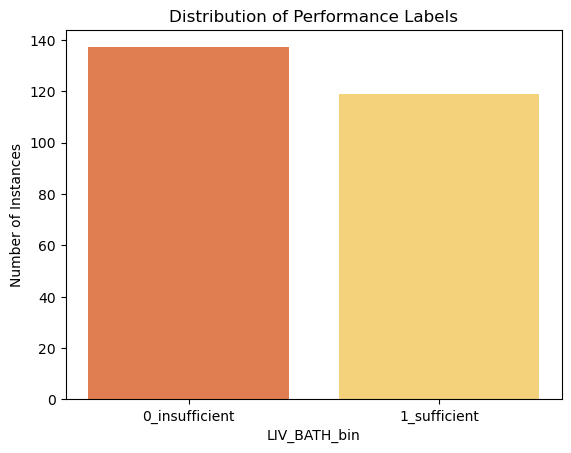

Number of unique 'unit_id' values: 256
Index(['apartment_id', 'site_id', 'building_id', 'plan_id', 'floor_id',
       'unit_id', 'area_id', 'unit_usage', 'entity_type', 'entity_subtype',
       'geometry', 'elevation', 'height', 'LIV_KIT', 'LIV_BED1', 'LIV_BED2',
       'LIV_BED3', 'LIV_BED4', 'LIV_BED5', 'LIV_BED6', '# OF BEDS',
       'LIV_BATH1', 'LIV_BATH2', 'LIV_BATH3', '# OF BATH', 'invalid_geometry',
       'LIV_KIT_bin', 'LIV_KIT_bin_mapped', 'layout_compactness',
       'layout_std_walllengths', 'layout_perimeter', 'layout_door_perimeter',
       'layout_open_perimeter', 'layout_number_of_doors',
       'connectivity_entrance_door_distance_max',
       'connectivity_entrance_door_distance_mean',
       'connectivity_entrance_door_distance_median',
       'connectivity_entrance_door_distance_min',
       'connectivity_entrance_door_distance_p20',
       'connectivity_entrance_door_distance_p80',
       'connectivity_entrance_door_distance_stddev',
       'connectivity_betweenne

In [4]:
# Add sightlines from living to toilet label with two possible classes: insufficient and sufficient
training_df['LIV_BATH_bin'] = training_df[['LIV_BATH1', 'LIV_BATH2']].max(axis=1).apply(lambda x: '0_insufficient' if x == 0 else '1_sufficient').astype(str)

# Get the counts of each category
value_counts = training_df['LIV_BATH_bin'].value_counts()
print(training_df['LIV_BATH_bin'].value_counts())

# Specify the desired order
order = ['0_insufficient', '1_sufficient']

# Reorder value_counts based on the specified order and fill missing categories with 0
ordered_values = [value_counts.get(cat, 0) for cat in order]
colors = [hist_palette[cat] for cat in order]

# Create a bar plot with the specified order
plt.bar(order, ordered_values, color=colors)
plt.xlabel('LIV_BATH_bin')
plt.ylabel('Number of Instances')
plt.title('Distribution of Performance Labels')
plt.show()

# Check the number of unique 'unit_id' values in the training_set DataFrame
unique_unit_ids = training_df['unit_id'].nunique()
print("Number of unique 'unit_id' values:", unique_unit_ids)
print(training_df.columns)


# Adding the bin map integers for each class

# Define a mapping dictionary
bin_mapping = {'0_insufficient': 0, '1_sufficient': 1}

# Map the values and create a new column
training_df['LIV_BATH_bin_mapped'] = training_df['LIV_BATH_bin'].map(bin_mapping)

pd.set_option('display.max_columns', None)  # Display all columns
print(training_df.dtypes)

Notice that the last two columns are the living to bathroom classes

### Step 3: Feature Selection
In this notebook we will use the sequential feature selection algorithm. <br>
We want to test the entire feature list to see how well they help with predicting a correct label based on the isovist values. <br>
In this step, I identify all the possible features relevant for the model and take one value from them. I.e., take the mean 20 and 80 percentile values.<br>

In [5]:
"""Manually select the features based on their indecies"""

# Create a DataFrame with column indices and names
index_names_df = pd.DataFrame({'Index': range(len(training_df.columns)), 'Column Name': training_df.columns})

# Convert DataFrame to a list of tuples (index, column name)
index_names_list = list(index_names_df.to_records(index=False))

# Print the list of tuples
print("List of column indices and names:")
print(index_names_list)


List of column indices and names:
[(0, 'apartment_id'), (1, 'site_id'), (2, 'building_id'), (3, 'plan_id'), (4, 'floor_id'), (5, 'unit_id'), (6, 'area_id'), (7, 'unit_usage'), (8, 'entity_type'), (9, 'entity_subtype'), (10, 'geometry'), (11, 'elevation'), (12, 'height'), (13, 'LIV_KIT'), (14, 'LIV_BED1'), (15, 'LIV_BED2'), (16, 'LIV_BED3'), (17, 'LIV_BED4'), (18, 'LIV_BED5'), (19, 'LIV_BED6'), (20, '# OF BEDS'), (21, 'LIV_BATH1'), (22, 'LIV_BATH2'), (23, 'LIV_BATH3'), (24, '# OF BATH'), (25, 'invalid_geometry'), (26, 'LIV_KIT_bin'), (27, 'LIV_KIT_bin_mapped'), (28, 'layout_compactness'), (29, 'layout_std_walllengths'), (30, 'layout_perimeter'), (31, 'layout_door_perimeter'), (32, 'layout_open_perimeter'), (33, 'layout_number_of_doors'), (34, 'connectivity_entrance_door_distance_max'), (35, 'connectivity_entrance_door_distance_mean'), (36, 'connectivity_entrance_door_distance_median'), (37, 'connectivity_entrance_door_distance_min'), (38, 'connectivity_entrance_door_distance_p20'), (39,

Select the feature set, including the <u>target variables</u> for of isovist value bin classes, by assigning a number to each feature to call out the ones relevant based on their index value

In [6]:
# Add all fitures from simulation file 
column_indices = [[26,27,71,72], # All isovist assessment result classes
                  [28,29,30,31,32,32,33], # Layout compactness
                  [], # Adjacencies and relationships
                  [], # Centrality 
                  [38,39], # Distance to entrance door 
                  [45,46], # Betweenness
                  [52,53], # Closeness
                  [], # (living?) Room distances
                  [], # Living - Dining distance
                  [59,60], # Bathroom distance
                  [66,67], # Kitchen distance
                  [], # Distance to balcony
                  [69,70]] # Layout biggest rectangle length and width



# Rename the dataframe with the final selection
df_sel = training_df.iloc[:, [item for sublist in column_indices for item in sublist]]

# Get column names of Swiss_sim_selected
column_names = list(training_df.columns)
print(column_names)

['apartment_id', 'site_id', 'building_id', 'plan_id', 'floor_id', 'unit_id', 'area_id', 'unit_usage', 'entity_type', 'entity_subtype', 'geometry', 'elevation', 'height', 'LIV_KIT', 'LIV_BED1', 'LIV_BED2', 'LIV_BED3', 'LIV_BED4', 'LIV_BED5', 'LIV_BED6', '# OF BEDS', 'LIV_BATH1', 'LIV_BATH2', 'LIV_BATH3', '# OF BATH', 'invalid_geometry', 'LIV_KIT_bin', 'LIV_KIT_bin_mapped', 'layout_compactness', 'layout_std_walllengths', 'layout_perimeter', 'layout_door_perimeter', 'layout_open_perimeter', 'layout_number_of_doors', 'connectivity_entrance_door_distance_max', 'connectivity_entrance_door_distance_mean', 'connectivity_entrance_door_distance_median', 'connectivity_entrance_door_distance_min', 'connectivity_entrance_door_distance_p20', 'connectivity_entrance_door_distance_p80', 'connectivity_entrance_door_distance_stddev', 'connectivity_betweenness_centrality_max', 'connectivity_betweenness_centrality_mean', 'connectivity_betweenness_centrality_median', 'connectivity_betweenness_centrality_min

## Step 4: Setting up the model's parameters

## Introduction

We will be using the random forest classifier to predict the floor layout class based on the Swiss Dwelligns simulation features.<br>
The feature selection will evaluate the accuracy of the prediction using two metrics: the individual class accuracy and the multi-output class accuracy. <br>
In summary, we can evalaute the performance of the model on an individual class and the overall model's accuracy by across all multiclass outputs.<br>

##  Custom Scoring Function for Subset Accuracy
In this section, we define and implement a custom scoring function specifically designed for multi-output classification tasks. This custom scoring function, known as subset accuracy, evaluates the performance of our model by checking if all predicted labels for each instance match the true labels exactly.<br><br>
Why Subset Accuracy?<br><br>

- Stringency: Subset accuracy is a stringent metric. It considers a prediction correct only if all labels for an instance are correctly predicted. This means that even if only one label is incorrect, the entire prediction for that instance is considered incorrect.<br>
- Comprehensive Evaluation: This metric provides a comprehensive evaluation of our model's performance, ensuring that the model performs well across all outputs, not just on average.
- Applicability: Subset accuracy is particularly useful in scenarios where partial correctness is not acceptable, such as in medical diagnoses, safety systems, or quality control.<br><br>
<br>
The custom scoring function subset_accuracy_score is defined as follows:
<br>
- y_true == y_pred: Creates a boolean array indicating which predictions match the true values.<br>
- np.all(..., axis=1): Checks if all labels for each instance are correct.<br>
- np.mean(...): Calculates the mean of these boolean values, providing the subset accuracy score.<br><br>

We then wrap this function using make_scorer from scikit-learn to make it compatible with scikit-learn's model selection and evaluation tools:
<br>
This custom scorer will be used in subsequent steps, such as hyperparameter tuning and feature selection, to ensure that our model is evaluated and optimized based on its ability to predict all output labels correctly for each instance.<br>


https://scikit-learn.org/stable/modules/model_evaluation.html


### Custom Scoring Functions for Multi-Label Classification

In this section, we define two custom scoring metrics: **Subset Accuracy** and **Hamming Loss**, both useful for evaluating multi-label classification tasks. These metrics provide different perspectives on model performance, with varying levels of strictness.

1. **Subset Accuracy**:
    - Subset accuracy is a **strict metric** for multi-label classification.
    - It considers a prediction correct **only if all labels** for a given instance are predicted correctly.
    - This means even a single incorrect label for an instance will result in the entire prediction being marked incorrect.
    - **Use case**: Best when you want to ensure that every label is predicted accurately without tolerance for partial correctness.

2. **Hamming Loss**:
    - Hamming loss is a **less strict metric** that measures the fraction of **incorrect labels**.
    - It penalizes each misclassified label individually, making it more tolerant to partially correct predictions.
    - **Use case**: Useful when individual label correctness is more important than predicting the entire set of labels perfectly.

#### Difference:
- **Subset accuracy** gives a more rigid evaluation, emphasizing full correctness of all labels for each instance. 
- **Hamming loss**, on the other hand, provides a more granular view by evaluating each label independently, making it more forgiving of partial errors.
  
Both metrics offer valuable insights depending on how strict you want to be in assessing the correctness of multi-label predictions.

The `print('OK!')` statement simply confirms successful initialization.


In [7]:
# Custom scoring function for subset accuracy
def subset_accuracy_score(y_true, y_pred):
    return np.mean(np.all(y_true == y_pred, axis=1))
subset_accuracy_scorer = make_scorer(subset_accuracy_score)

# Custom scoring function for Hamming loss
def hamming_loss_score(y_true, y_pred):
    return np.sum(y_true.values != y_pred) / np.size(y_true)
hamming_loss_scorer = make_scorer(hamming_loss_score, greater_is_better=False)

print('OK!')


OK!


### Features and Target Splits
We separate the features and target variables and then split the data into training and testing sets.

In [8]:
# Setup the model's parameter  here
# Model parameters
test_size = 0.3
random_state = 42  # Fixed random state for reproducibility
cv_folds = 5
n_estimator = 300

# Set up cross-validation with a fixed random seed
cv = KFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

print('OK!')

OK!


In [9]:
# Assign training classes with multiple outputs
X = df_sel.drop(columns=[
    'LIV_KIT_bin', 
    'LIV_KIT_bin_mapped', 
    'LIV_BATH_bin', 
    'LIV_BATH_bin_mapped'
    # 'LIV_BED_bin' # not yet included in the code due to inconsistencies in the data generated from Grasshopper
])
y = df_sel[['LIV_KIT_bin', 'LIV_BATH_bin']] #removed: 'LIV_BED_bin'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

print('OK!')


OK!


### Initializing the Random Forest Classifier

In this step, we initialize a `RandomForestClassifier` from the `sklearn.ensemble` module. The `random_state` parameter is set to ensure reproducibility by controlling the randomness in the model's decision tree generation.

- `rf = RandomForestClassifier(random_state=random_state)`: Initializes the classifier and assigns it to the variable `rf`.
- This model is now ready to be trained on data for classification tasks.

In [10]:
# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=random_state)

print('OK!')

OK!


### Initializing a Multi-Target Random Forest Classifier

In this step, we initialize a `RandomForestClassifier` to handle multi-target classification by wrapping it in a `MultiOutputClassifier`.

- `multi_target_rf = RandomForestClassifier(n_estimators=n_estimator, random_state=random_state)`: Initializes the `RandomForestClassifier` with 300 trees, taken from the parameter specified earlier `n_estimator` and assigns it to `multi_target_rf`.
- This classifier is now ready to handle tasks where multiple target labels are predicted simultaneously.

In [11]:
# Wrap the RandomForestClassifier in a MultiOutputClassifier
multi_target_rf = RandomForestClassifier(n_estimators=n_estimator, random_state=random_state)

print('OK!')


OK!


### Selecting Features for Training

In this step, we prepare the features for training and feature selection:

- `num_of_features = X_train.shape[1]`: Determines the number of features (columns) in the training set `X_train`.
- `train_features = X_train.columns.tolist()`: Converts the column names (features) of `X_train` into a list for easier manipulation.
  
The number of features and the feature names are printed for reference.


In [12]:
# Select all the features in the train set for feature selection

num_of_features = X_train.shape[1]
print('Number of features to train on is', num_of_features)
train_features = X_train.columns.tolist()
print(train_features)

Number of features to train on is 19
['layout_compactness', 'layout_std_walllengths', 'layout_perimeter', 'layout_door_perimeter', 'layout_open_perimeter', 'layout_open_perimeter', 'layout_number_of_doors', 'connectivity_entrance_door_distance_p20', 'connectivity_entrance_door_distance_p80', 'connectivity_betweenness_centrality_p20', 'connectivity_betweenness_centrality_p80', 'connectivity_closeness_centrality_p20', 'connectivity_closeness_centrality_p80', 'connectivity_bathroom_distance_p20', 'connectivity_bathroom_distance_p80', 'connectivity_kitchen_distance_p20', 'connectivity_kitchen_distance_p80', 'layout_biggest_rectangle_length', 'layout_biggest_rectangle_width']


## Step 5: Sequential Feature Selection

### Sequential Feature Selection with Random Forest and Custom Scoring

This code performs feature selection using a **Sequential Feature Selector (SFS)** with a **Random Forest** classifier and custom scoring functions. Here's a breakdown of the process:

1. **Custom Scoring Functions**:
   - `hamming_loss_score`: Calculates the Hamming loss, a measure of how many labels are incorrectly predicted.
   - `subset_accuracy_score`: Measures the subset accuracy, which only considers a prediction correct if all labels are predicted correctly.
   - These functions are wrapped with `make_scorer` to be compatible with scikit-learn’s scoring system.

2. **Sequential Feature Selection (SFS)**:
   - The code runs a **forward feature selection** using `SequentialFeatureSelector` to find the optimal number of features that maximize **subset accuracy**.
   - The loop iterates through different numbers of features, from 1 to the maximum number (`max_n_features`), evaluating models using **cross-validation** (`cv`).

3. **Model Training and Evaluation**:
   - For each subset of selected features, a new Random Forest model is trained, and the predictions are evaluated using both **Hamming loss** and **Subset accuracy**.
   - The results, including the number of features, Hamming loss, and subset accuracy, are printed for debugging purposes.

4. **Tracking Best Features**:
   - The model tracks the subset with the highest **subset accuracy** and stores the corresponding feature set.
   - This ensures that the final selection is based on the subset that produces the best performance.

5. **Plotting the Results**:
   - After the loop completes, the Hamming loss and subset accuracy are plotted against the number of selected features to visualize the trade-off between the two metrics.

6. **Final Output**:
   - The best number of features and the selected features are printed.
   - A plot is generated showing how the Hamming loss and subset accuracy change as the number of features increases.


Sequential Forward Selection (SFS) method<br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html

Number of features: 1
Selected features: Index(['layout_door_perimeter'], dtype='object')
Hamming loss: 0.4155844155844156
Subset accuracy: 0.33766233766233766
Number of features: 2
Selected features: Index(['layout_door_perimeter', 'connectivity_bathroom_distance_p20'], dtype='object')
Hamming loss: 0.2727272727272727
Subset accuracy: 0.5454545454545454
Number of features: 3
Selected features: Index(['layout_door_perimeter', 'connectivity_bathroom_distance_p20',
       'connectivity_kitchen_distance_p20'],
      dtype='object')
Hamming loss: 0.19480519480519481
Subset accuracy: 0.6493506493506493
Number of features: 4
Selected features: Index(['layout_door_perimeter', 'connectivity_bathroom_distance_p20',
       'connectivity_kitchen_distance_p20', 'layout_biggest_rectangle_width'],
      dtype='object')
Hamming loss: 0.22727272727272727
Subset accuracy: 0.6103896103896104
Number of features: 5
Selected features: Index(['layout_std_walllengths', 'layout_door_perimeter',
       'connec

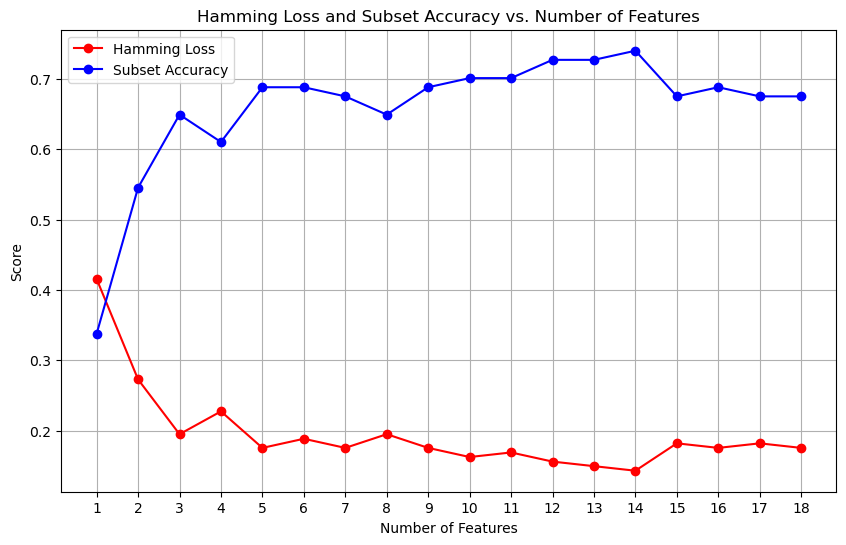

In [13]:
# Custom scoring functions
def hamming_loss_score(y_true, y_pred):
    return np.sum(y_true.values != y_pred) / np.size(y_true)

def subset_accuracy_score(y_true, y_pred):
    return np.mean(np.all(y_true == y_pred, axis=1))

hamming_loss_scorer = make_scorer(hamming_loss_score, greater_is_better=False)
subset_accuracy_scorer = make_scorer(subset_accuracy_score, greater_is_better=True)

# Maximum number of features to select
max_n_features = min(num_of_features, X_train.shape[1])

# Initialize variables to track the best score and features
best_score = 0  # Start with the lowest possible value since we are maximizing subset accuracy
best_features = None
feature_counts = []
hamming_losses = []
subset_accuracies = []

# Sequential Feature Selector with a limit on the number of features
for n_features in range(1, max_n_features + 1):
    multi_target_rf = RandomForestClassifier(n_estimators=n_estimator, random_state=random_state)
    
    sfs = SequentialFeatureSelector(
        multi_target_rf, 
        n_features_to_select=n_features, 
        direction='forward', 
        scoring=subset_accuracy_scorer,  # Optimize for subset accuracy
        cv=cv, 
        n_jobs=-1
    )
    try:
        sfs.fit(X_train, y_train)
        X_train_selected = sfs.transform(X_train)
        X_test_selected = sfs.transform(X_test)  # Transform the test set using the selected features
        
        # Reinitialize the random forest model
        multi_target_rf = RandomForestClassifier(random_state=random_state)  # Ensure to use the same random parameters as before
        multi_target_rf.fit(X_train_selected, y_train)
        y_test_pred = multi_target_rf.predict(X_test_selected)
        
        hamming_loss = hamming_loss_score(y_test, y_test_pred)  # Calculate Hamming loss on the test set
        subset_accuracy = subset_accuracy_score(y_test, y_test_pred)  # Calculate subset accuracy on the test set
        
        # Debugging: Print intermediate results
        print(f"Number of features: {n_features}")
        print(f"Selected features: {X_train.columns[sfs.get_support()]}")
        print(f"Hamming loss: {hamming_loss}")
        print(f"Subset accuracy: {subset_accuracy}")
        
        feature_counts.append(n_features)
        hamming_losses.append(hamming_loss)
        subset_accuracies.append(subset_accuracy)
        
        if subset_accuracy > best_score:
            best_score = subset_accuracy
            best_features = X_train.columns[sfs.get_support()]
            best_n_features = n_features
    except Exception as e:
        print(f"Error with {n_features} features: {e}")

# Output the best number of features and the selected features
print(f"Best number of features: {best_n_features}")
print(f"Selected features: {best_features}")

# Plot the Hamming loss and subset accuracy scores
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, hamming_losses, marker='o', label='Hamming Loss', color='red')
plt.plot(feature_counts, subset_accuracies, marker='o', label='Subset Accuracy', color='blue')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.title('Hamming Loss and Subset Accuracy vs. Number of Features')
plt.grid(True)
plt.legend()
plt.xticks(feature_counts)  # Set x-ticks to full integer values
plt.show()


## Step 6: Random Forest Hyperparameter Tuning and Model Evaluation for Multi-Label Classification


This code performs **hyperparameter tuning** for a **Random Forest** model in a multi-label classification problem using **GridSearchCV**. It then evaluates the model on test data and calculates various metrics, including **Hamming Loss** and **Subset Accuracy**.

#### Breakdown:

1. **Define Hyperparameters for Grid Search**:
   - `param_grid` specifies the hyperparameters of the Random Forest to be tuned, such as the number of trees (`n_estimators`), maximum depth of the trees (`max_depth`), and more.
   - Parameters are searched over various values to find the combination that maximizes the model's performance.

2. **Feature Selection**:
   - `X_train_selected` and `X_test_selected` include only the best features from the feature selection process (stored in `best_features`).
   
3. **Grid Search with MultiOutputClassifier**:
   - The `MultiOutputClassifier` is initialized with a `RandomForestClassifier` to handle multi-target classification.
   - `GridSearchCV` is used to perform a cross-validated search over the specified hyperparameters (`param_grid`). It evaluates each combination of parameters using the custom **subset accuracy scorer** and selects the best configuration.

4. **Fit the Model**:
   - The grid search is fitted to the training data (`X_train_selected`, `y_train`), and the best parameters are identified.

5. **Predict and Evaluate**:
   - The best model (`best_rf`) is used to make predictions on the test set (`X_test_selected`).
   - **Accuracy, Classification Report, and Confusion Matrix** are generated for each target label in the dataset. Confusion matrices are visualized using heatmaps for easier interpretation.

6. **Calculate Hamming Loss and Subset Accuracy**:
   - **Hamming Loss**: Measures the fraction of labels that are incorrectly predicted. Calculated manually using a custom function `calculate_hamming_loss()`.
   - **Subset Accuracy**: This is the strictest metric where a prediction is considered correct only if all labels are predicted correctly for an instance.

#### Key Outputs:
- **Best Parameters**: The best combination of hyperparameters found by GridSearchCV.
- **Accuracy and Classification Report**: For each individual target label.
- **Confusion Matrices**: Visualized as heatmaps for each target label.
- **Hamming Loss**: Provides a general measure of prediction error.
- **Subset Accuracy**: Indicates how often all labels for an instance are predicted correctly.


Fitting 5 folds for each of 1620 candidates, totalling 8100 fits


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
2700 fits failed out of a total of 8100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1828 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\multioutput.py", line 537, in fit
    super().fit(X, Y, sample_weight=sample_weight, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
     


Best Parameters found by GridSearchCV:
{'estimator__max_depth': None, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 205}
Accuracy for LIV_KIT_bin: 0.8441558441558441
Classification Report for LIV_KIT_bin:
                precision    recall  f1-score   support

0_insufficient       0.79      0.90      0.84        30
  1_sufficient       0.81      0.74      0.77        23
   2_preferred       0.95      0.88      0.91        24

      accuracy                           0.84        77
     macro avg       0.85      0.84      0.84        77
  weighted avg       0.85      0.84      0.84        77



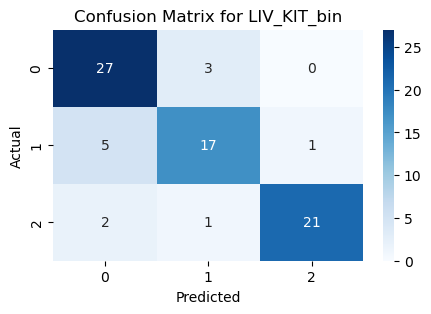

Accuracy for LIV_BATH_bin: 0.8051948051948052
Classification Report for LIV_BATH_bin:
                precision    recall  f1-score   support

0_insufficient       0.82      0.79      0.81        39
  1_sufficient       0.79      0.82      0.81        38

      accuracy                           0.81        77
     macro avg       0.81      0.81      0.81        77
  weighted avg       0.81      0.81      0.81        77



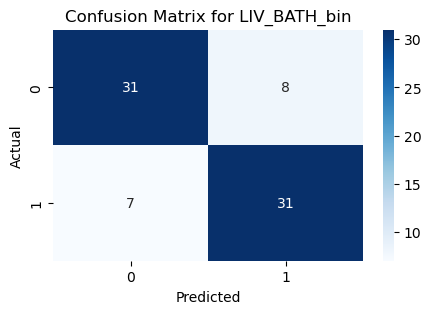

Hamming Loss: 0.17532467532467533
Subset Accuracy: 0.6753246753246753


In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputClassifier



# Define hyperparameters for grid search
param_grid = {
    'estimator__n_estimators': [int(x) for x in np.linspace(start=50, stop=750, num=10)],  # Number of trees in the forest
    # 'estimator__criterion': ['gini', 'entropy'],  # Function to measure the quality of a split
    'estimator__max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'estimator__min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'estimator__max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider when looking for the best split
    # 'estimator__bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
    # 'estimator__max_leaf_nodes': [None, 10, 20, 30],  # Maximum number of leaf nodes
    # 'estimator__min_impurity_decrease': [0.0, 0.01, 0.1],  # Minimum impurity decrease to split a node
    # 'estimator__oob_score': [False, True],  # Whether to use out-of-bag samples to estimate the generalization accuracy
    # 'estimator__warm_start': [False, True],  # Reuse the solution of the previous call to fit and add more estimators to the ensemble
    # 'estimator__n_jobs': [None, -1]  # Number of jobs to run in parallel
}


# Transform the training and testing sets to include only the best features
X_train_selected = X_train[best_features]
X_test_selected = X_test[best_features]

# Initialize GridSearchCV with the MultiOutputClassifier and the parameter grid
multi_target_rf = MultiOutputClassifier(RandomForestClassifier(random_state=random_state))
grid_search = GridSearchCV(estimator=multi_target_rf, param_grid=param_grid, cv=cv, scoring=subset_accuracy_scorer, verbose=2, n_jobs=-1)

# Fit the GridSearchCV to the training data with selected features
grid_search.fit(X_train_selected, y_train)

# Print the best parameters found by GridSearchCV
print("\nBest Parameters found by GridSearchCV:")
print(grid_search.best_params_)

# Train the model using the best parameters
best_rf = grid_search.best_estimator_

# Predict on the testing set with selected features
y_pred_test = best_rf.predict(X_test_selected)

# Evaluate each output individually
for i, col in enumerate(y_train.columns):
    accuracy = accuracy_score(y_test.iloc[:, i], y_pred_test[:, i])
    print(f"Accuracy for {col}: {accuracy}")
    print(f"Classification Report for {col}:\n{classification_report(y_test.iloc[:, i], y_pred_test[:, i])}")
    cm = confusion_matrix(y_test.iloc[:, i], y_pred_test[:, i])
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {col}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Calculate Hamming loss manually
def calculate_hamming_loss(y_true, y_pred):
    return np.sum(y_true.values != y_pred) / np.size(y_true)

hamming = calculate_hamming_loss(y_test, y_pred_test)
print(f"Hamming Loss: {hamming}")

# Calculate subset accuracy
subset_accuracy = np.mean(np.all(y_test.values == y_pred_test, axis=1))
print(f"Subset Accuracy: {subset_accuracy}")


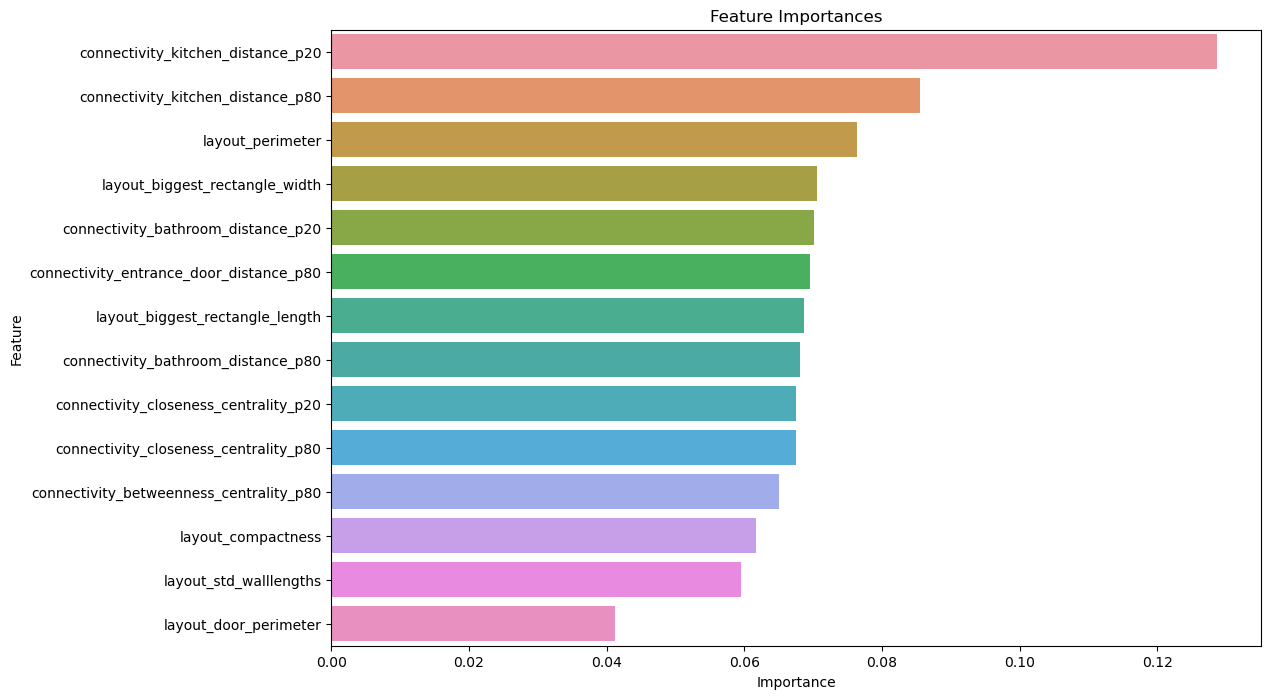

In [15]:
# After the completion of the evaluation and confusion matrix

# Extract feature importances from each RandomForestClassifier in the MultiOutputClassifier
feature_importances = np.zeros(X_train_selected.shape[1])

for estimator in best_rf.estimators_:
    feature_importances += estimator.feature_importances_

# Average the feature importances
feature_importances /= len(best_rf.estimators_)

# Create a DataFrame for visualization
importances_df = pd.DataFrame({
    'feature': X_train_selected.columns,
    'importance': feature_importances
})

# Sort by importance
importances_df = importances_df.sort_values(by='importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importances_df)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()
